<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from commpy.modulation import Modem, QAMModem
from commpy.utilities  import signal_power, upsample, bitarray2dec, dec2bitarray
from commpy.filters    import rrcosfilter
from scipy.signal import lfilter
from sympy.combinatorics.graycode import GrayCode
from numpy.matlib import repmat
from numpy.random import randint

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special as spec

In [123]:
def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]

def Qfunc(x):
    return 0.5-0.5*spec.erf(x/np.sqrt(2))

def theoryBER(M, EbN0, constType):
    
    EbN0lin = 10**(EbN0/10)        
    k  = np.log2(M) 
    
    if constType == 'qam':
        L  = np.sqrt(M)      
        Pb = 2*(1-1/L)/np.log2(L)*Qfunc(np.sqrt(3*np.log2(L)/(L**2-1)*(2*EbN0lin)))
        
    elif constType == 'psk':
        Ps = 2*Qfunc(np.sqrt(2*k*EbN0lin)*np.sin(np.pi/M))
        Pb = Ps/k
    
    return Pb  

def GrayMapping(M, constType):
    
    L   = int(np.sqrt(M)-1)
    bitsSymb = int(np.log2(M))
    
    code = GrayCode(bitsSymb)
    a    = list(code.generate_gray())
    
    if constType == 'qam':
        PAM = np.arange(-L, L+1, 2)
        PAM = np.array([PAM])

        # generate complex square M-QAM constellation
        const = repmat(PAM, L+1, 1) + 1j*repmat(np.flip(PAM.T,0), 1, L+1)
        const = const.T
    
        for ind in np.arange(1,L+1,2):
            const[ind] = np.flip(const[ind],0)        
        
    elif constType == 'psk':
        pskPhases = np.arange(0,2*np.pi,2*np.pi/M)
        
        # generate complex M-PSK constellation
        const     = np.exp(1j*pskPhases) 
    
    const    = const.reshape(M,1)
    const_   = np.zeros((M,2),dtype=complex)
    

    for ind in range(0,M):    
        const_[ind,0]   = const[ind,0]   # complex constellation symbol
        const_[ind,1]   =  int(a[ind],2) # mapped bit sequence (as integer decimal)
        
    # sort complex symbols column according to their mapped bit sequence (as integer decimal)                 
    const = const_[const_[:,1].real.argsort()] 
    
    return const


def hdDecision(symb, const):
    return abs(symb - const).argmin(0)


def modulateGray(bits, M, constType):
       
    bitsSymb = int(np.log2(M))      
    const = GrayMapping(M, constType)
    
    symb    = bits.reshape(-1,bitsSymb).T
    symbInd = bitarray2dec(symb)    

    return const[symbInd,0]


def demodulateGray(symb, M ,constType):
    
    const = GrayMapping(M, constType)
         
    hdDecision_vec = np.vectorize(hdDecision, excluded = [1])        
    index_list = hdDecision_vec(symb, const[:,0])     
    demod_bits = dec2bitarray(index_list, int(np.log2(M)))
    
    return demod_bits

def pulseShape(pulseType, SpS=2, N=1024, alpha=0.1, Ts=1):
    
    Fa = (1/Ts)*SpS
    
    t = np.linspace(-2, 2, SpS)
    Te = 1       
    
    if pulseType == 'rect':
        filterCoeffs = np.ones(SpS)        
    elif pulseType == 'nrz':
        filterCoeffs = np.convolve(np.ones(SpS), 2/(np.sqrt(np.pi)*Te)*np.exp(-t**2/Te), mode='full')        
    elif pulseType == 'rrc':
        tindex, filterCoeffs = rrcosfilter(N, alpha, Ts, Fa)
        
    return filterCoeffs/np.sqrt(np.sum(filterCoeffs**2))
    

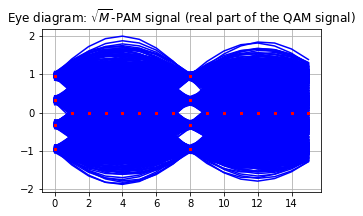

In [167]:
# simulation parameters

M   = 16  # Modulation order
SpS = 8

Rs     = 32e9
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
alpha  = 0.05          # Rolloff do filtro RRC
N      = 1024          # Número de coeficientes do filtro RRC
EbN0dB = 20
   
# generate random bits
bitsTx   = np.random.randint(2, size=3*2**12)    

# map bits to constellation symbols
mod = QAMModem(m=M)
symbTx = mod.modulate(bitsTx)
Es = mod.Es;

# normalize symbols energy to 1
symbTx = symbTx/np.sqrt(Es)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulse shaping
#pulseFilter = pulseShape('rrc', SpS, N, alpha, Ts)
tindex, rrcFilter = rrcosfilter(N, alpha, Ts, Fa)
sigTx  = filterNoDelay(pulseFilter, symbolsUp)     
sigTx  = sigTx/np.sqrt(signal_power(sigTx))

# plot eye diagrams
plt.figure(1,figsize=(5,3));
plt.title('Eye diagram: $\sqrt{M}$-PAM signal (real part of the QAM signal)');
plt.plot(np.transpose(sigTx.real.reshape(int(sigTx.size/(2*SpS)),2*SpS)),color='blue');
plt.plot(np.transpose(symbolsUp.real.reshape(int(symbolsUp.size/(2*SpS)),2*SpS)),'.',markersize=2.5, color='red');
plt.grid()

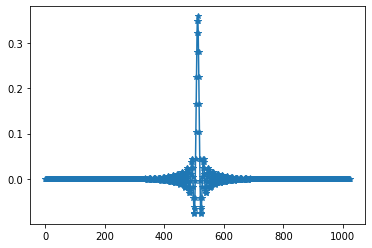

In [131]:
plt.figure()
plt.plot(pulseFilter,'-*');

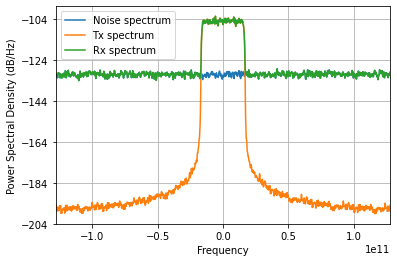

In [168]:
# AWGN channel
snrdB    = EbN0dB + 10*np.log10(np.log2(M))
noiseVar = 1/(10**(snrdB/10))

σ        = np.sqrt(noiseVar*SpS)
noise    = np.random.normal(0,σ, symbolsUp.size) + 1j*np.random.normal(0,σ, symbolsUp.size)
noise    = 1/np.sqrt(2)*noise    

sigRx = sigTx + noise   

# plot spectrums
plt.figure(2);
plt.psd(noise,Fs=Fa, NFFT = 1024, label = 'Noise spectrum')
plt.psd(sigTx,Fs=Fa, NFFT = 1024, label = 'Tx spectrum')
plt.psd(sigRx,Fs=Fa, NFFT = 1024, label = 'Rx spectrum')
plt.legend(loc='upper left');
plt.xlim(-Fa/2,Fa/2);

EbN0: 20.00 dB, EbN0_est: 19.91 dB,
BERtheory: 0.0e+00, BER: 0.0e+00 
Total of bits counted:  11888


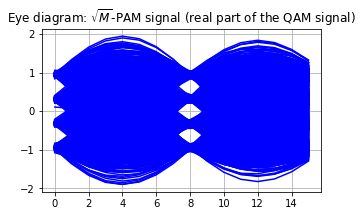

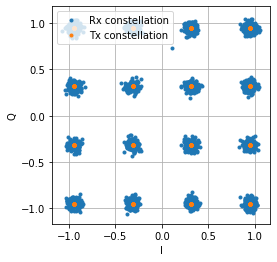

In [169]:
# matched filter
sigRx = filterNoDelay(rrcFilter, sigRx)    
sigRx = sigRx/SpS

# plot eye diagrams
plt.figure(3,figsize=(5,3));
plt.title('Eye diagram: $\sqrt{M}$-PAM signal (real part of the QAM signal)');
plt.plot(np.transpose(sigRx.real.reshape(int(sigRx.size/(2*SpS)),2*SpS)),color='blue');
plt.grid()

# downsampling to one sample per symbol
symbRx = sigRx[0::SpS]
#symbRx = symbRx/np.sqrt(signal_power(symbRx))

# demodulate received symbols        
bitsRx = mod.demodulate(np.sqrt(Es)*symbRx, demod_type = 'hard') 

# BER calculation
discard = 200
numBits = bitsTx.size

ERR = np.logical_xor(bitsRx[discard:numBits-discard], bitsTx[discard:numBits-discard])
BER = ERR.sum()/ERR.size

# EbN0 estimation
EbN0dB_est = 10*np.log10(1/(signal_power(symbRx-symbTx)*np.log2(M)))

BERtheory = theoryBER(M, EbN0dB,'qam')

# print results
print('EbN0: %3.2f dB, EbN0_est: %3.2f dB,\nBERtheory: %3.1e, BER: %3.1e ' %(EbN0dB, EbN0dB_est, BERtheory, BER))   
print('Total of bits counted: ', ERR.size)

# plot constellations
plt.figure(4)
plt.plot(symbRx.real,symbRx.imag,'.', label ='Rx constellation');
plt.plot(symbTx.real,symbTx.imag,'.', label ='Tx constellation')
plt.legend(loc='upper left');
plt.xlabel('I');
plt.ylabel('Q');
plt.grid()
plt.axis('square');

In [9]:
# Run BER vs EbN0 Monte Carlo simulation 

M   = 64  # Modulation order
SpS = 4

Ts  = 1             # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
alpha = 0.05        # Rolloff do filtro RRC
N     = 1024        # Número de coeficientes do filtro RRC

EbN0dB_    = np.arange(10,20.5,0.5)
BER        = np.zeros(EbN0dB_.shape)
EbN0dB_est = np.zeros(EbN0dB_.shape)

for indSNR in range(EbN0dB_.size):
    
    EbN0dB = EbN0dB_[indSNR]
    
    # generate random bits
    bitsTx   = np.random.randint(2, size=3*2**18)    

    # map bits to constellation symbols
    mod = QAMModem(m=M)
    symbTx = mod.modulate(bitsTx)
    Es = mod.Es;
    
    # Normalize symbols energy to 1
    symbTx = symbTx/np.sqrt(Es)
    
    # Aumenta a taxa de amostragem do sinal para SpS amostras/símbolo
    symbolsUp = upsample(symbTx, SpS)
                                   
    # filtro formatador de pulso 
    tindex, rrcFilter = rrcosfilter(N, alpha, Ts, Fa)
    symbolsUp  = filterNoDelay(rrcFilter, symbolsUp)     
    symbolsUp  = symbolsUp/np.sqrt(signal_power(symbolsUp))
    
    # AWGN channel
    snrdB    = EbN0dB + 10*np.log10(np.log2(M))
    noiseVar = 1/(10**(snrdB/10))

    σ        = np.sqrt(noiseVar*SpS)
    noise    = np.random.normal(0,σ, symbolsUp.size) + 1j*np.random.normal(0,σ, symbolsUp.size)
    noise    = 1/np.sqrt(2)*noise    

    symbRx = symbolsUp + noise   
     
    # filtro casado
    symbRx = filterNoDelay(rrcFilter, symbRx)    
    symbRx = symbRx/SpS
    
    # Decimação para uma amostra por símbolo
    symbRx = symbRx[0::SpS]
        
    # Demodulate received symbols        
    bitsRx = mod.demodulate(np.sqrt(Es)*symbRx, demod_type = 'hard') 
    discard = 100
    numBits = bitsTx.size;
    
    # BER calculation, EbN0 estimation
    ERR = np.logical_xor(bitsRx[discard:numBits-discard], bitsTx[discard:numBits-discard])
    BER[indSNR] = ERR.sum()/ERR.size
    EbN0dB_est[indSNR] = 10*np.log10(1/(signal_power(symbRx-symbTx)*np.log2(M)))
    
    print('EbN0: %3.2f dB, EbN0_est: %3.2f dB, BER: %3.1e ' %(EbN0dB, EbN0dB_est[indSNR], BER[indSNR]))    


print('Total of bits counted: ', ERR.size)

EbN0: 10.00 dB, EbN0_est: 10.01 dB, BER: 2.6e-02 
EbN0: 10.50 dB, EbN0_est: 10.46 dB, BER: 2.2e-02 
EbN0: 11.00 dB, EbN0_est: 11.00 dB, BER: 1.7e-02 
EbN0: 11.50 dB, EbN0_est: 11.49 dB, BER: 1.3e-02 
EbN0: 12.00 dB, EbN0_est: 12.01 dB, BER: 9.7e-03 
EbN0: 12.50 dB, EbN0_est: 12.49 dB, BER: 7.1e-03 
EbN0: 13.00 dB, EbN0_est: 12.99 dB, BER: 5.0e-03 
EbN0: 13.50 dB, EbN0_est: 13.49 dB, BER: 3.4e-03 
EbN0: 14.00 dB, EbN0_est: 14.00 dB, BER: 2.1e-03 
EbN0: 14.50 dB, EbN0_est: 14.49 dB, BER: 1.4e-03 
EbN0: 15.00 dB, EbN0_est: 15.01 dB, BER: 7.6e-04 
EbN0: 15.50 dB, EbN0_est: 15.50 dB, BER: 4.3e-04 
EbN0: 16.00 dB, EbN0_est: 16.00 dB, BER: 2.2e-04 
EbN0: 16.50 dB, EbN0_est: 16.49 dB, BER: 1.0e-04 
EbN0: 17.00 dB, EbN0_est: 17.02 dB, BER: 4.5e-05 
EbN0: 17.50 dB, EbN0_est: 17.53 dB, BER: 2.0e-05 
EbN0: 18.00 dB, EbN0_est: 18.00 dB, BER: 6.4e-06 
EbN0: 18.50 dB, EbN0_est: 18.49 dB, BER: 1.3e-06 
EbN0: 19.00 dB, EbN0_est: 19.00 dB, BER: 2.5e-06 
EbN0: 19.50 dB, EbN0_est: 19.49 dB, BER: 0.0e+00 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


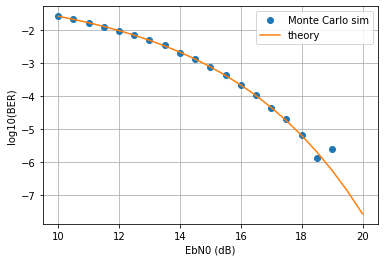

In [10]:
# Plot simulation results and theoretical curves        
BERtheory = theoryBER(M, EbN0dB_,'qam')   

plt.plot(EbN0dB_,np.log10(BER),'o', label='Monte Carlo sim');
plt.plot(EbN0dB_, np.log10(BERtheory), label = 'theory')
plt.legend();
plt.xlabel('EbN0 (dB)');
plt.ylabel('log10(BER)');
plt.grid()